In [1]:
import time
import pandas as pd
import numpy as np
import sys
import re
sys.path.append('../Modules')
from ts_correlation import *
from variation_information import *
from utils_clustering import *
from preprocess_series import *
import seaborn
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from tslearn.clustering import silhouette_score
from read_prepare_input_clustering import *
from utils_clustering_time_windows import *
from tsmoothie.smoother import *
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.neighbors import NearestCentroid

In [2]:
## PARAMETERS

# Number of days in each time window
window_shape = 90

# Specify whether you want to use data transformed via autoencoder
use_autoencoder = True

# Specify whether you want to use data in the latent representation provided by the time series encoder
use_encoded_values = False

# Distance metric for clustering algorithm
distance_metric = 'euclidean'

# Specify whether you want to use first-order differences or work with raw time series
use_differences = False

# Specify whether you want to subtract series barycenter from each series
# If so, specify metric for barycenter computation
subtract_sector_barycenter = False
sector_barycenter_metric = 'euclidean'

# Class used to scale time series data
# - TimeSeriesScalerMinMax(): scaling each series between min and max value
# - TimeSeriesScalerMeanVariance(): scaling each series to have mean mu and unitary standard deviation
# - None for no scaling
time_series_scaler = TimeSeriesScalerMinMax()

# Max number of clusters in the experiments
max_num_clusters = 30

# CLustering algorithm
# - kMeans
# - hierarchical
clustering_algorithm = 'hierarchical'

# Linkage hierarchical clustering
linkage_hierarchical_clustering = 'ward'

# Remove correlated risk factors
rem_corr_rf = False
corr_threshold = 0.7

# Metric to link issuer curves and risk factors to evaluate risk factor effect on curves in the same cluster
#  - 'corr' -> linear correlation
#  - 'corr_based_dist' -> correlation-based distance
#  - 'varInfo' -> variation of information
link_metrics = 'corr_based_dist'

# Number of top risk factors to include
num_top_rf = 5

In [3]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf()

risk_factors_to_include = list(pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';').iloc[:, 1])

In [4]:
# Remove series having more than 90% NA values

df_all_lookup_complete = remove_series_mostly_na(df_all_lookup, 0.9)
obs_universe_local = remove_series_mostly_na(obs_universe_local, 0.9)
obs_universe_fx = remove_series_mostly_na(obs_universe_fx, 0.9)

print('Min date in observation universe fx: ' + str(min(obs_universe_fx.index)))
print('Max date in observation universe fx: ' + str(max(obs_universe_fx.index)))
print('\n')

print('Min date in observation universe local: ' + str(min(obs_universe_local.index)))
print('Max date in observation universe local: ' + str(max(obs_universe_local.index)))
print('\n')

print('Min date in curves df: ' + str(min(df_all_lookup_complete.index)))
print('Max date in curves df: ' + str(max(df_all_lookup_complete.index)))

min_dates = [min(obs_universe_fx.index), min(obs_universe_local.index), min(df_all_lookup_complete.index)]
max_dates = [max(obs_universe_fx.index), max(obs_universe_local.index), max(df_all_lookup_complete.index)]

# Min and max dates for which we have all data available
lb_dates = max(min_dates)
ub_dates = min(max_dates)

df_all_lookup_filtered = df_all_lookup_complete[(df_all_lookup_complete.index >= lb_dates) & 
                                                (df_all_lookup_complete.index <= ub_dates)]
df_universe_fx_filtered = obs_universe_fx[(obs_universe_fx.index >= lb_dates) &
                                          (obs_universe_fx.index <= ub_dates)]
df_universe_local_filtered = obs_universe_local[(obs_universe_local.index >= lb_dates) &
                                                (obs_universe_local.index <= ub_dates)]

df_risk_factors = pd.concat([df_universe_fx_filtered, df_universe_local_filtered], axis=1)
risk_factors_to_include_available = list(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))
df_complete = df_risk_factors[risk_factors_to_include_available]

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Min date in observation universe fx: 2015-05-15 00:00:00
Max date in observation universe fx: 2022-05-13 00:00:00


Min date in observation universe local: 2015-05-15 00:00:00
Max date in observation universe local: 2022-05-13 00:00:00


Min date in curves df: 2015-05-21 00:00:00
Max date in curves df: 2021-12-06 00:00:00


In [5]:
# #### READ TIME SERIES FITTED BY GARCH MODEL

# temp = pd.read_csv('cond_vola_risk_factors.csv', sep=';')
# temp = temp.rename(columns={'Date[Date]': 'Date'}).set_index('Date', drop=True)
# temp = temp.loc[:, risk_factors_to_include_available]
# df_complete = temp.copy()

In [6]:
# Check correlation between risk factors
if rem_corr_rf:
    rf_to_remove = remove_correlated_risk_factors(df_complete, risk_factors_to_include, corr_threshold,
                                                 rf_to_keep=['VIX (16)[CBOE - Market Volatility Index]'])
    risk_factors_to_include_available = list(set(risk_factors_to_include_available).difference(set(rf_to_remove)))
    print(str(len(set(rf_to_remove))) + ' risk factors removed due to high correlation: ' + str(set(rf_to_remove)))

In [7]:
df_transposed = df_complete.T.loc[risk_factors_to_include_available, :]
df_transposed.shape

(20, 1708)

In [ ]:
if use_encoded_values:

    df_encoded = pd.read_csv('encoded_series_risk_factors.csv', sep=';').\
        set_index('curveId', drop=True)

    time_windows, string_time_windows = get_time_windows_bounds(df_transposed, window_shape)

    num_windows = len(time_windows)

    window_values = split_series_in_time_windows(df_encoded, window_shape=int(df_encoded.shape[1]/num_windows),
                                                 return_smooth=False)

In [9]:
if use_autoencoder:

    df_decoded = pd.read_csv('../Output/4.3_Clustering_Results/Series_Post_Autoencoder/decoded_series_risk_factors.csv', sep=';').\
        set_index('curveId', drop=True)
    df_transposed_bkp = df_transposed.copy()
    df_transposed = df_decoded.copy()
    
    time_series_scaler = None

In [10]:
if not use_encoded_values:

    # Generate time windows for all series in the dataframe
    # Time windows are disjoint, there is no overlapping between two different windows generated from the same series
    window_values = split_series_in_time_windows(df_transposed, window_shape, time_series_scaler=time_series_scaler,
                                                return_smooth=False)

    # Compute time windows start and end dates
    time_windows, string_time_windows = get_time_windows_bounds(df_transposed, window_shape)

In [12]:
# K-Means clustering

if clustering_algorithm == 'kMeans':
    
    start = time.time()
    clustering_results, silhouette_scores, inertia_scores = \
        try_k_means_varying_k(window_values, use_ts_kmeans=True, metric_distance=distance_metric,
                              min_num_clusters = 2, max_num_clusters = 17, n_init = 2)
    print('Elapsed time: ' + str(time.time() - start))
    
    # Elbow plot of inertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

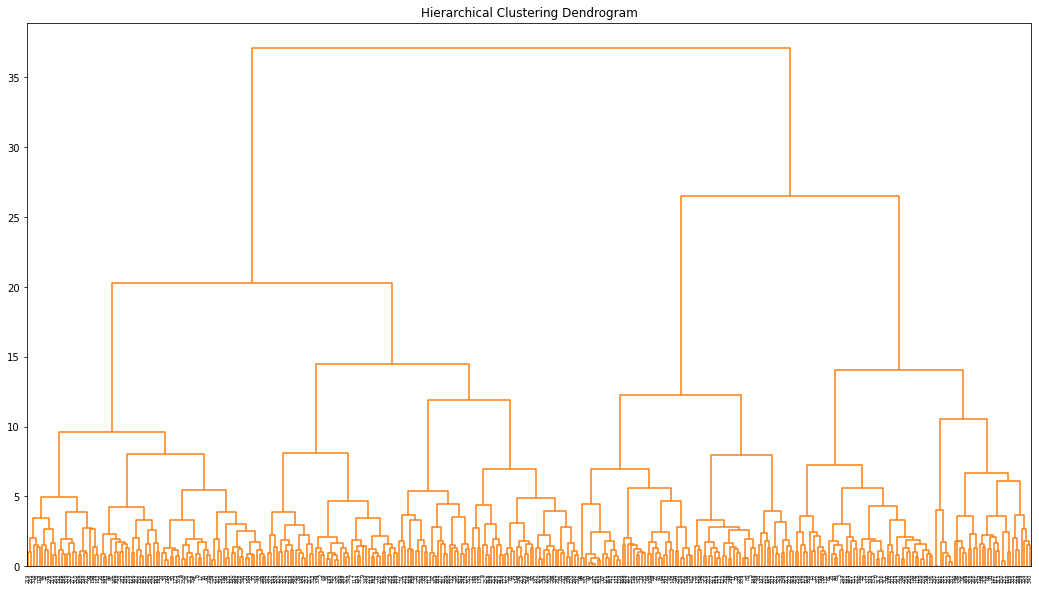

Elapsed time: 12.271695613861084


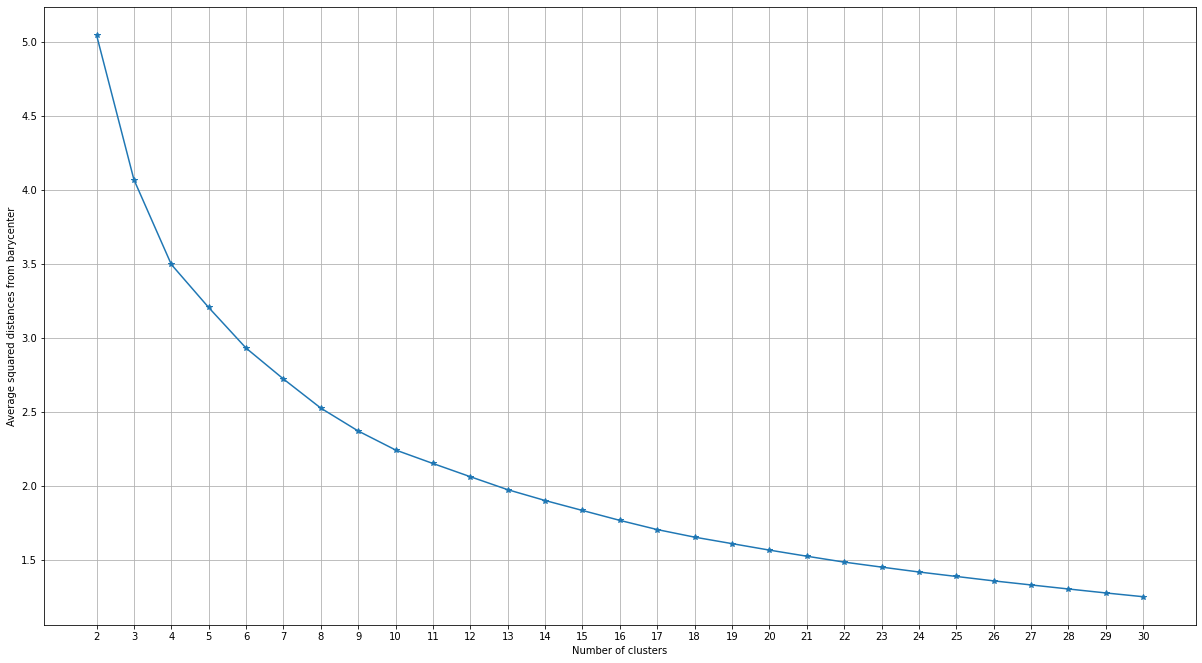

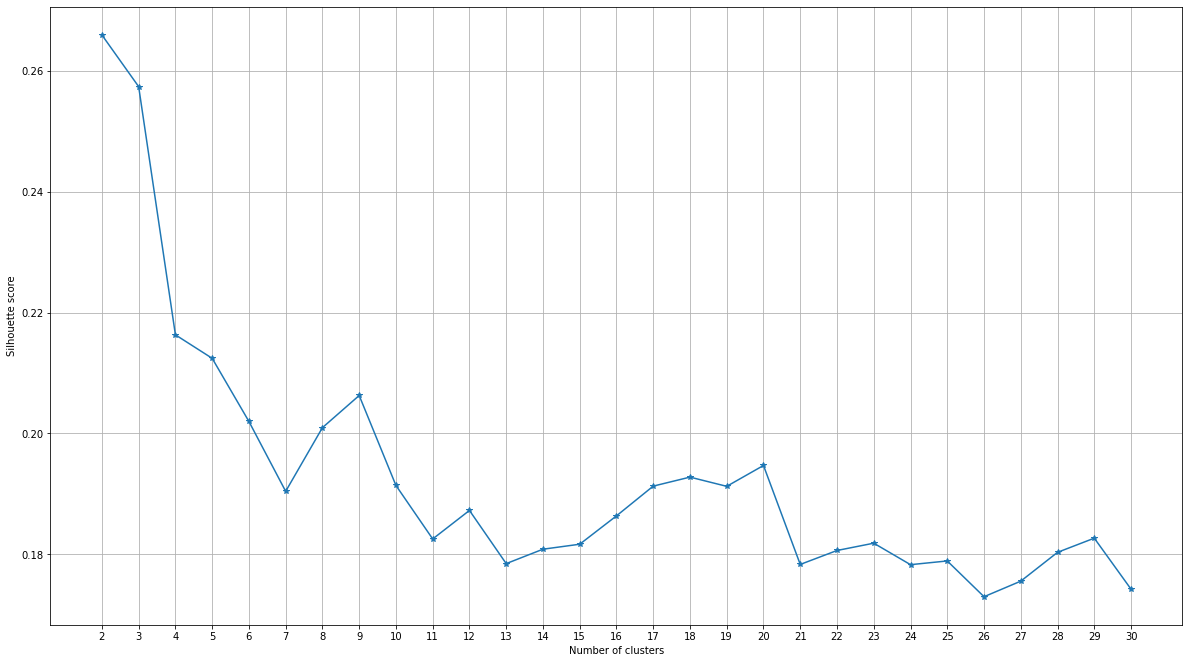

In [13]:
# Hierarchical clustering

if clustering_algorithm == 'hierarchical':

    start = time.time()
    
    hier_clust_fit, linkage = \
        hierarchical_clustering_and_dendrogram(window_values.reshape(window_values.shape[0], window_values.shape[1]),
                                                                    linkage_hierarchical_clustering)

    # Find clustering results for different values of number of clusters from dendrogram
    clustering_results = {}
    for i in range(2, max_num_clusters+1):
        clusters = fcluster(linkage, t=i, criterion='maxclust')
        clustering_results[i] = clusters

    # Silhouette scores and inertia for the different numbers of clusters
    silhouette_scores = {}
    inertia_scores = {}
    for i in clustering_results:
        sil_score = silhouette_score(window_values.reshape(window_values.shape[0], window_values.shape[1]),
                                     clustering_results[i], metric='euclidean')
        silhouette_scores[i] = sil_score
        inertia_scores[i] = compute_inertia(pd.DataFrame(window_values.reshape(window_values.shape[0], window_values.shape[1])),
                                                         clustering_results[i])
        
    print('Elapsed time: ' + str(time.time() - start))

    # Plot of insertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

In [14]:
# Build df with curve id as index and a column per each time window, specifying cluster where the curve belongs
# to in that time windows

# Number of clusters for the result to be saved
num_clusters = 5

clusters_per_curve = {}
num_windows = int(np.floor(df_transposed.shape[1]/window_shape))
for i in range(len(df_transposed.index)):
    labels_curr_curve = clustering_results[num_clusters][i*num_windows:((i+1)*num_windows)]
    clusters_per_curve[df_transposed.index[i]] = labels_curr_curve

df_clustering_results = pd.DataFrame(clusters_per_curve.items(), columns=['curveId', 'list_clusters'])
df_clustering_results = df_clustering_results.set_index('curveId', drop=True)
df_clustering_results =  pd.concat([df_clustering_results[c].apply(pd.Series).add_prefix(c + "_") for c in df_clustering_results], axis=1)

In [15]:
# Set time windows extreme dates as columns of the df with clustering results        
        
df_clustering_results.columns = list(string_time_windows.values())

In [16]:
# Replace risk factors' names with their short version.
# This is done to avoid issues due to backslash character in complete name

mapping_rf_names = pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';')
df_clustering_results = df_clustering_results.reset_index().rename(columns={'curveId': 'complete_name'}).\
    merge(mapping_rf_names, how='left').\
    assign(short_name = lambda x: np.where(pd.isna(x['short_name']), x['complete_name'], x['short_name'])).\
    rename(columns={'short_name': 'curveId'}).\
    set_index('curveId', drop=True).drop(columns=['complete_name'])
df_clustering_results

2015/05/21-2015/09/23  \
curveId                                                                     
UTS000000055702777_1M                                                   5   
US CPI A-3L BEI Govt (SP)_60M                                           4   
STOXX50E                                                                4   
UTS000000055702776_1M                                                   4   
CNY Govt (NS)_60M                                                       5   
CNY 3M Swap (SP) 1Y LPR_60M                                             5   
EUR Govt_60M                                                            5   
USD Govt - On the Run (SP)_60M                                          4   
RMXIX3106772677                                                         2   
RMXIX3107873667                                                         4   
UTS000000052590996_30D                                                  5   
JPY (8)[Foreign Exchange Spot Rate - Japan (JPY)]                       3   
EUR ATM Swaption 50 5Y 10Y                                              5   
Nikkei                                                                  4   
USD ATM Swaption 50 5Y 10Y                                              3   
USD (11)[Foreign Exchange Spot Rate - United St...                      4   
EU HICPxT A-3L BEI Govt_60M                                             4   
UTS000000055702779_1M                                                   5   
VIX                                                                     2   
S&P 500                                                                 4   

                                                    2015/09/24-2016/01/27  \
curveId                                                                     
UTS000000055702777_1M                                                   4   
US CPI A-3L BEI Govt (SP)_60M                                           4   
STOXX50E                                                                4   
UTS000000055702776_1M                                                   4   
CNY Govt (NS)_60M                                                       4   
CNY 3M Swap (SP) 1Y LPR_60M                                             5   
EUR Govt_60M                                                            4   
USD Govt - On the Run (SP)_60M                                          1   
RMXIX3106772677                                                         2   
RMXIX3107873667                                                         4   
UTS000000052590996_30D                                                  5   
JPY (8)[Foreign Exchange Spot Rate - Japan (JPY)]                       2   
EUR ATM Swaption 50 5Y 10Y                                              5   
Nikkei                                                                  4   
USD ATM Swaption 50 5Y 10Y                                              2   
USD (11)[Foreign Exchange Spot Rate - United St...                      1   
EU HICPxT A-3L BEI Govt_60M                                             4   
UTS000000055702779_1M                                                   5   
VIX                                                                     2   
S&P 500                                                                 4   

                                                    2016/01/28-2016/06/01  \
curveId                                                                     
UTS000000055702777_1M                                                   2   
US CPI A-3L BEI Govt (SP)_60M                                           1   
STOXX50E                                                                1   
UTS000000055702776_1M                                                   2   
CNY Govt (NS)_60M                                                       3   
CNY 3M Swap (SP) 1Y LPR_60M                                             1   
EUR Govt_60M                                  

In [18]:
df_clustering_results.reset_index().\
    to_csv('../Output/4.3_Clustering_Results/clust_rf_time_windows_autoencoder.csv', sep=';', index=False)

## Plot clusters centres and samples

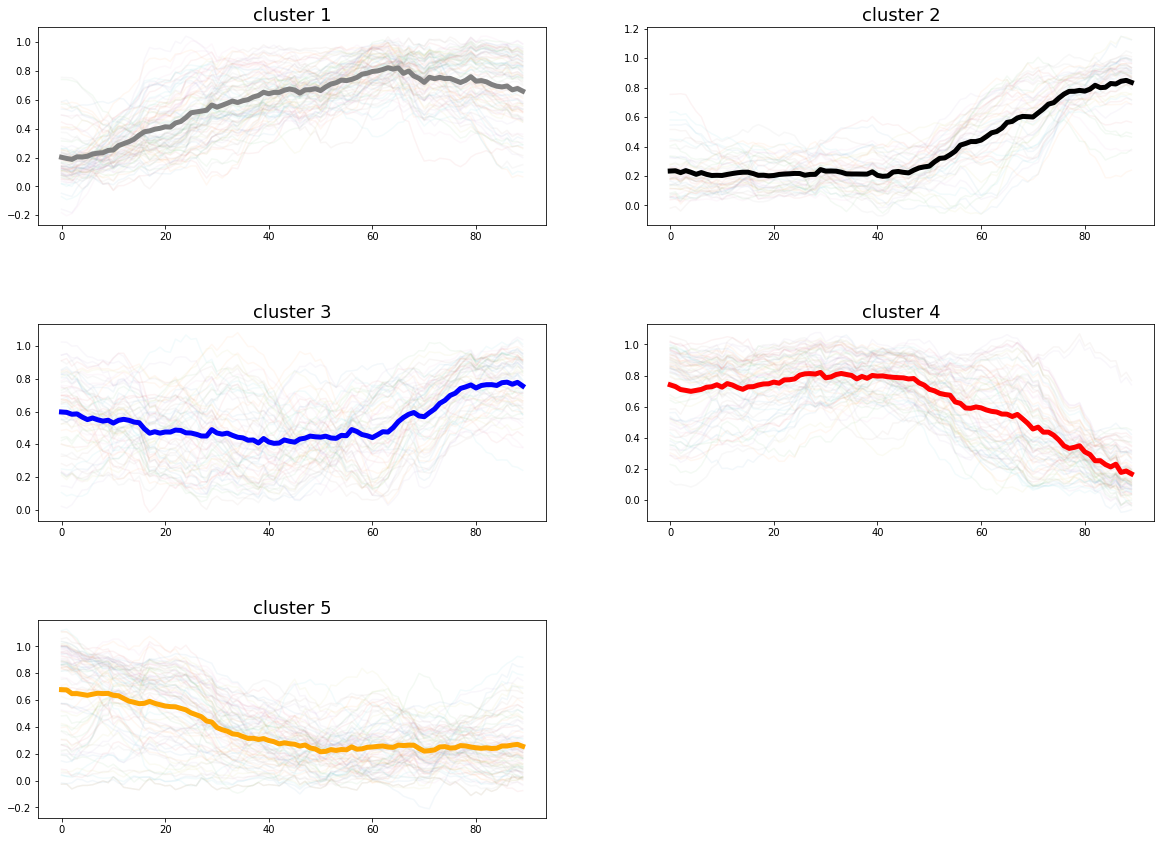

In [19]:
### PLOT CLUSTER CENTERS WITH SAMPLES ###
# Preprocessed series is shown, so after rescaling and other operations done on raw series

if clustering_algorithm == 'kMeans':

    km_fit = TimeSeriesKMeans(n_clusters=num_clusters, metric=distance_metric, max_iter=50, random_state=0, n_init=2,
                                          max_iter_barycenter=10).fit(window_values)
    clust_labels = km_fit.labels_
    centroids = km_fit.cluster_centers_
    
else:
    
    clf = NearestCentroid()
    clf.fit(np.squeeze(window_values), clustering_results[num_clusters])
    clust_labels = clustering_results[num_clusters]
    centroids = clf.centroids_
    

fig = plt.figure()

if clustering_algorithm == 'hierarchical':
    colors = {1: 'grey', 2: 'black', 3: 'blue', 4: 'red', 5: 'orange',
              6: 'yellow', 7: 'purple', 8: 'pink', 9: 'brown', 10: 'magenta'}
else:
    colors = {0: 'grey', 1: 'black', 2: 'blue', 3: 'red', 4: 'orange',
              5: 'yellow', 6: 'purple', 7: 'pink', 8: 'brown', 9: 'magenta'}
    
for c in range(len(list(set(clust_labels)))):
    
    cluster_label = list(set(clust_labels))[c]
   
    ax = fig.add_subplot(4, 2, c+1)
    # Plot preprocessed series and barycenters
    ax.plot(np.squeeze(window_values[clust_labels == cluster_label]).T, alpha=0.05)
    ax.plot(np.squeeze(centroids)[c], linewidth=5, color=colors[cluster_label])
    
    plt.title(f"cluster {cluster_label}", fontsize=18)
    
    
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(20, 20)
fig.savefig('pattern_clusters_risk_factors_autoencoder_' + str(num_clusters) + '.png', facecolor='white')

## Identify risk factors closest to barycenters in each cluster and time window

In [20]:
# - Fixed time window tw
#    - Fixed cluster cl
#       - Determine barycenter of cluster cl in time window tw
#       - Find closest risk factors to barycenter in cluster cl in time window tw

# NOTE: In this way, I compute the barycenter per each cl-tw. Another option may be using the overall cluster barycenter
#       resulting from the fitting of the clustering algorithm.
#       The ratio behind computing each time the barycenter is to take into account the values of the series in that
#       specific time window, while the overall barycenter may be affected by different values taken in the other
#       time windows.

# NOTE: It is important to compute barycenters and distances always on rescaled values (values in window_values) since
#       different factors often have completely different order of magnitudes in the raw series

In [26]:
# Replace risk factors' names with their short version.
# This is done to avoid issues due to backslash character in complete name

df_transposed = df_transposed.reset_index().rename(columns={'index': 'complete_name', 'curveId': 'complete_name'}).\
    merge(mapping_rf_names, how='left').\
    assign(short_name = lambda x: np.where(pd.isna(x['short_name']), x['complete_name'], x['short_name'])).\
    rename(columns={'short_name': 'curveId'}).\
    set_index('curveId', drop=True).drop(columns=['complete_name'])
df_transposed

2015-05-21  2015-05-22  \
curveId                                                                      
UTS000000055702777_1M                                 0.892580    0.879921   
US CPI A-3L BEI Govt (SP)_60M                         0.844524    0.827073   
STOXX50E                                              0.939250    0.923457   
UTS000000055702776_1M                                 0.529288    0.501600   
CNY Govt (NS)_60M                                     0.410481    0.409988   
CNY 3M Swap (SP) 1Y LPR_60M                           0.922669    0.926932   
EUR Govt_60M                                          0.370491    0.361883   
USD Govt - On the Run (SP)_60M                        0.489888    0.473880   
RMXIX3106772677                                       0.132213    0.137220   
RMXIX3107873667                                       0.914293    0.901827   
UTS000000052590996_30D                                1.003354    0.998810   
JPY (8)[Foreign Exchange Spot Rate - Japan (JPY)]     0.699230    0.693181   
EUR ATM Swaption 50 5Y 10Y                            0.816007    0.828144   
Nikkei                                                0.901631    0.886764   
USD ATM Swaption 50 5Y 10Y                            0.648007    0.662747   
USD (11)[Foreign Exchange Spot Rate - United St...    0.848060    0.835364   
EU HICPxT A-3L BEI Govt_60M                           0.791630    0.774201   
UTS000000055702779_1M                                 0.986151    0.975154   
VIX                                                   0.082487    0.092981   
S&P 500                                               0.965626    0.948062   

                                                    2015-05-25  2015-05-26  \
curveId                                                                      
UTS000000055702777_1M                                 0.864086    0.851414   
US CPI A-3L BEI Govt (SP)_60M                         0.817106    0.795293   
STOXX50E                                              0.909618    0.930640   
UTS000000055702776_1M                                 0.516859    0.472421   
CNY Govt (NS)_60M                                     0.375960    0.409264   
CNY 3M Swap (SP) 1Y LPR_60M                           0.866696    0.886402   
EUR Govt_60M                                          0.324200    0.326694   
USD Govt - On the Run (SP)_60M                        0.454684    0.473898   
RMXIX3106772677                                       0.112096    0.101700   
RMXIX3107873667                                       0.889907    0.904042   
UTS000000052590996_30D                                0.981457    0.939595   
JPY (8)[Foreign Exchange Spot Rate - Japan (JPY)]     0.702642    0.657401   
EUR ATM Swaption 50 5Y 10Y                            0.788357    0.798976   
Nikkei                                                0.872583    0.892365   
USD ATM Swaption 50 5Y 10Y                            0.623543    0.644604   
USD (11)[Foreign Exchange Spot Rate - United St...    0.834488    0.831987   
EU HICPxT A-3L BEI Govt_60M                           0.775136    0.768734   
UTS000000055702779_1M                                 0.957848    0.938947   
VIX                                                   0.052850    0.039986   
S&P 500                                               0.940849    0.953657   

                                                    2015-05-27  2015-05-28  \
curveId                                                                      
UTS000000055702777_1M                                 0.843782    0.846325   
US CPI A-3L BEI Govt (SP)_60M                         0.789143    0.797242   
STOXX50E                                              0.900056    0.898289   
UTS000000055702776_1M                                 0.438413    0.442738   
CNY Govt (NS)_60M                                     0.454771    0.475716   
CNY 3M Swap (SP) 1Y LPR_60M                           0.893529    0.9000

In [27]:
# Per each time window and cluster, compute distance of all risk factors from cluster barycenter
# in order to find the closest risk factors to the barycenter of each cluster in each time window
# Cluster centroid is computed in each cluster-time_window from the series in that cluster during that time window

curve_ids = list(df_transposed.index)
curve_ids = [ele for ele in curve_ids for i in range(len(time_windows))]
tws = [ele for i in range(len(df_transposed.index)) for ele in list(time_windows.keys())]
window_values_test = pd.DataFrame(np.squeeze(window_values)).assign(curveId = curve_ids, time_window = tws)

centroids = np.squeeze(centroids)
clusters_list = np.array(list(set(clustering_results[num_clusters])))

distances_per_tw_cl = {}
for tw in time_windows:
    df_curr_tw = window_values_test.loc[lambda x: x['time_window'] == tw].drop(columns='time_window')
    clustering_curr_tw = df_clustering_results.reset_index()[['curveId', string_time_windows[tw]]]
    df_curr_tw = df_curr_tw.merge(clustering_curr_tw).rename(columns={string_time_windows[tw]: 'cluster_label'}).\
        set_index('curveId', drop=True)
    
    distances_per_tw_cl[tw] = {}
    for cl in df_curr_tw['cluster_label'].unique():
        df_curr_cl = df_curr_tw.loc[lambda x: x['cluster_label'] == cl].drop(columns=['cluster_label'])
        centr_curr_cl = np.array(df_curr_cl.apply(np.average)).reshape(1, window_shape)
        distances = cdist(df_curr_cl, centr_curr_cl)
        df_curr_cl['dist_from_cen'] = distances
        distances_per_tw_cl[tw][cl] = df_curr_cl[['dist_from_cen']].sort_values(by='dist_from_cen', ascending=True)

In [105]:
# Read info about type of the risk factors
rf_types = pd.read_csv('../Data/RISK_FACTOR_TYPE.csv', sep=';')

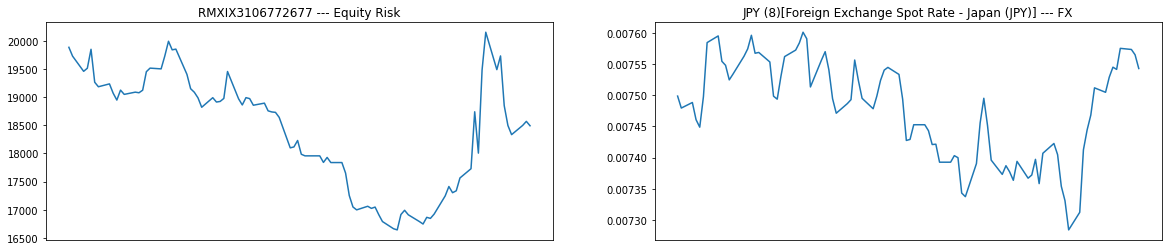

In [156]:
# Plot the series of the first two risk factors in a certain time window and cluster.
# Ranking is based on distance from cluster centroid

tw = 7
cl = 6

fig = plt.figure()
i = 1
temp_distances_per_tw_cl = distances_per_tw_cl[tw][cl].head(2)
num_curves_tw_cl = len(temp_distances_per_tw_cl)
for curve in temp_distances_per_tw_cl.index:
    ax = fig.add_subplot(1,num_curves_tw_cl,i)
    i += 1
    ax.plot(df_transposed.loc[curve, (df_transposed.columns >= time_windows[tw][0]) &
                                     (df_transposed.columns <= time_windows[tw][1])])
    distance = temp_distances_per_tw_cl.loc[curve, 'dist_from_cen']
    rf_type = rf_types.loc[lambda x: x['RISK_FACTOR'] == curve].reset_index()['TYPE'][0]
    plt.xticks([])
    plt.title(f"{curve} --- {rf_type}")

# fig.subplots_adjust(hspace=1.5)
fig.set_size_inches(20, 4)
fig.savefig('tw_' + str(tw) + '_cl_' + str(cl) + '.png', facecolor='white')

In [88]:
# Save clustering results for each time window

for tw in distances_per_tw_cl:
    curr_tw = pd.DataFrame()
    for cl in distances_per_tw_cl[tw]:
        tw_cl = distances_per_tw_cl[tw][cl].reset_index()
        tw_cl['cluster'] = cl
        tw_cl = tw_cl[['cluster', 'curveId', 'dist_from_cen']]
        curr_tw = pd.concat([curr_tw, tw_cl], ignore_index=True)
    curr_tw.sort_values(by=['cluster', 'dist_from_cen']).to_csv('tw_' + str(tw+1) + '.csv', sep=';', index=False)